# Loading Data

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from matplotlib.ticker import MaxNLocator, FuncFormatter, PercentFormatter
import pycountry_convert as pc


olymp = pd.read_csv("data/athlete_events.csv")
noc_regions = pd.read_csv("data/noc_regions.csv")
olymp.head(5)

ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's Football   NaN  
3       Tug-Of-War Men's Tug-Of-War  Gold  
4  Speed Skating Women's 500 metres   NaN

# Defining Questions

1. How has athlete participation changed over time across countries and continents? 
    - Method used: Linear regression, cross validated R^2
2. Which countries dominate Olympic performance, and how has dominance shifted over time?
    - Methods used: Medals by continent over time and slope trend tests
3. Can we predict if a country will win a medal at all based on its delegation size and historical characteristics?
    - Method used: ...
4. Does delegation size predict medal success? How strongly?
    - Method used: Random Forest Regressor predicting medal counts, cross validation, and feature importance
5. Which nations are the most medal efficient, and what factors explain medal efficiency?
    - Method used: Linear regression, bootstrap ci
6. Has gender representation become more balanced over time, and which regions are improving fastest?
    - Method used: Logistic regression
7. Do host nations experience a measurable boost in performance?
    - Method used: t-test, host vs non-host eda

# Data Collection

Our work uses the dataset titled 120 years of Olympic history: athletes and results on kaggle (https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). This is a public dataset that contaians information information since 1896 to 2016. The dataset has 271,116 rows where each row is corresponds to an individual athlete.

# Data Cleaning and Preparation

Talk about the steps we took mapping noc to actual country name and continent.
We also take only the summer olympics.
We will have to standardize country and region information, handle missing/problematic values, and aggregate data to country year summaries that we need for medal trends and participation.

Many demographic values contain missing entries. However, because our main research questions do not heavily rely on these features, and imputing historical physical data might introduce bias, we choose to exclude them from our analysis. The most important variables like Year, NOC, Medal, and Sex are all available.

To ensure accuracy and consistency in our analysis, we performed several data cleaning and preparation steps. Our cleaning process focused on:

1. Filtering to Summer Olympics only

2. Mapping NOC codes to consistent country names

3. Assigning each country to a continent

4. Handling missing or irrelevant fields

5. Engineering medal-related features

6. Aggregating the data to country-year level for later analysis

In [3]:
import pycountry_convert as pc # pip install pycountry pycountry_convert

# country mapping (making countries/continents consistent)
def country_to_continent(country):
    """
    Convert country name → continent name using pycountry_convert.
    Returns None if lookup fails.
    """
    try:
        iso = pc.country_name_to_country_alpha2(country)
        cont_code = pc.country_alpha2_to_continent_code(iso)
        return {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "OC": "Oceania",
            "SA": "South America"
        }[cont_code]
    except:
        return None

manual_continent_overrides = {
    "Serbia and Montenegro": "Europe",
    "Yugoslavia": "Europe",
    "Czechoslovakia": "Europe",
    "Syria": "Asia",
    "Hong Kong": "Asia",
    "Curacao": "North America",
    "Virgin Islands, US": "North America",
    "Virgin Islands, British": "North America",
    "West Indies Federation": "North America",
    "Refugee Olympic Team": None,
    "Individual Olympic Athletes": None,
    "NA": None,
}

def resolve_continent(row):
    country = row["country_name"]
    if country in manual_continent_overrides:
        return manual_continent_overrides[country]
    return country_to_continent(country)


host_country_map = {
    1896: "Greece",
    1900: "France",
    1904: "USA",
    1908: "UK",
    1912: "Sweden",
    1920: "Belgium",
    1924: "France",
    1928: "Netherlands",
    1932: "USA",
    1936: "Germany",
    1948: "UK",
    1952: "Finland",
    1956: "Australia",
    1960: "Italy",
    1964: "Japan",
    1968: "Mexico",
    1972: "Germany",
    1976: "Canada",
    1980: "Russia",           # USSR -> Russia
    1984: "USA",
    1988: "South Korea",
    1992: "Spain",
    1996: "USA",
    2000: "Australia",
    2004: "Greece",
    2008: "China",
    2012: "UK",
    2016: "Brazil", # we only have data to 2016
}


In [4]:
olympics_summer = olymp[olymp['Season'] == "Summer"]

# Merge NOC mappings
olympics_summer = olympics_summer.merge(noc_regions, on="NOC", how="left")
olympics_summer.rename(columns={"region": "country_name"}, inplace=True)

olympics_summer["continent"] = olympics_summer.apply(resolve_continent, axis=1)

# Medal quality fields
olympics_summer["has_medal"] = olympics_summer["Medal"].notna().astype(int)
olympics_summer["is_gold"]   = (olympics_summer["Medal"] == "Gold").astype(int)
olympics_summer["is_silver"] = (olympics_summer["Medal"] == "Silver").astype(int)
olympics_summer["is_bronze"] = (olympics_summer["Medal"] == "Bronze").astype(int)

medal_events = olympics_summer.dropna(subset=["Medal"]).copy()

# Count each Event+Medal once (team events => 1 medal)
unique_medals = (
    medal_events.groupby(["Year", "NOC", "country_name", "continent", "Event", "Medal"])
    .size()
    .reset_index(name="count")
)

# Each event-medal = 1 medal irrespective of athletes
unique_medals["medal_unit"] = 1

# Aggregate to country-year
country_year_medals = (
    unique_medals.groupby(["Year", "NOC", "country_name", "continent"])
    .agg(
        n_medals=("medal_unit", "sum"),
        n_gold=("Medal", lambda x: (x == "Gold").sum()),
        n_silver=("Medal", lambda x: (x == "Silver").sum()),
        n_bronze=("Medal", lambda x: (x == "Bronze").sum())
    )
    .reset_index()
)

# Now add athlete counts back in
athlete_counts = (
    olympics_summer.groupby(["Year", "NOC", "country_name", "continent"])
    .agg(n_athletes=("ID", lambda x: x.nunique()))
    .reset_index()
)

# Merge medals + athletes together
country_year = country_year_medals.merge(
    athlete_counts, on=["Year", "NOC", "country_name", "continent"], how="left"
)


country_year["total_medal_quality"] = (
    3 * country_year["n_gold"]
    + 2 * country_year["n_silver"]
    + 1 * country_year["n_bronze"]
)

# Medal efficiency
country_year["medals_per_athlete"] = (
    country_year["n_medals"] / country_year["n_athletes"]
).replace([float("inf"), -float("inf")], pd.NA)

# share of medals by continent over time
medals_continent_year = (
    country_year.groupby(["Year", "continent"])["n_medals"]
    .sum()
    .reset_index()
)

total_medals_year = (
    medals_continent_year.groupby("Year")["n_medals"]
    .sum()
    .reset_index(name="total_medals")
)

medals_continent_year = medals_continent_year.merge(total_medals_year, on="Year")
medals_continent_year["medal_share"] = (
    medals_continent_year["n_medals"] / medals_continent_year["total_medals"]
)

# Percent of athletes per continent each year
percent_athletes_continent_year = (
    country_year.dropna(subset=['continent'])
      .groupby(['continent','Year'], as_index=False)['n_athletes']
      .sum()
)
percent_athletes_continent_year['pct'] = percent_athletes_continent_year.groupby('Year')['n_athletes'].transform(
    lambda x: x / x.sum()
)

# adding host_country to data frame
country_year["host_country"] = country_year["Year"].map(host_country_map)
country_year["is_host"] = (country_year["country_name"] == country_year["host_country"]).astype(int)

# Data Analysis

## EDA

In [5]:
olympics_summer.head()

ID                                Name Sex   Age  Height  Weight  \
0   1                           A Dijiang   M  24.0   180.0    80.0   
1   2                            A Lamusi   M  23.0   170.0    60.0   
2   3                 Gunnar Nielsen Aaby   M  24.0     NaN     NaN   
3   4                Edgar Lindenau Aabye   M  34.0     NaN     NaN   
4   8  Cornelia "Cor" Aalten (-Strannood)   F  18.0   168.0     NaN   

             Team  NOC        Games  Year  ...       Sport  \
0           China  CHN  1992 Summer  1992  ...  Basketball   
1           China  CHN  2012 Summer  2012  ...        Judo   
2         Denmark  DEN  1920 Summer  1920  ...    Football   
3  Denmark/Sweden  DEN  1900 Summer  1900  ...  Tug-Of-War   
4     Netherlands  NED  1932 Summer  1932  ...   Athletics   

                          Event Medal country_name notes continent has_medal  \
0   Basketball Men's Basketball   NaN        China   NaN      Asia         0   
1  Judo Men's Extra-Lightweight   NaN        China   NaN      Asia         0   
2       Football Men's Football   NaN      Denmark   NaN    Europe         0   
3   Tug-Of-War Men's Tug-Of-War  Gold      Denmark   NaN    Europe         1   
4  Athletics Women's 100 metres   NaN  Netherlands   NaN    Europe         0   

  is_gold  is_silver  is_bronze  
0       0          0          0  
1       0          0          0  
2       0          0          0  
3       1          0          0  
4       0          0          0  

[5 rows x 22 columns]

In [6]:
olympics_summer.info()

olympics_summer.describe()
olympics_summer.columns
country_year.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222552 entries, 0 to 222551
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            222552 non-null  int64  
 1   Name          222552 non-null  object 
 2   Sex           222552 non-null  object 
 3   Age           213363 non-null  float64
 4   Height        170695 non-null  float64
 5   Weight        168698 non-null  float64
 6   Team          222552 non-null  object 
 7   NOC           222552 non-null  object 
 8   Games         222552 non-null  object 
 9   Year          222552 non-null  int64  
 10  Season        222552 non-null  object 
 11  City          222552 non-null  object 
 12  Sport         222552 non-null  object 
 13  Event         222552 non-null  object 
 14  Medal         34088 non-null   object 
 15  country_name  222182 non-null  object 
 16  notes         4401 non-null    object 
 17  continent     210325 non-null  object 
 18  has_

Index(['Year', 'NOC', 'country_name', 'continent', 'n_medals', 'n_gold',
       'n_silver', 'n_bronze', 'n_athletes', 'total_medal_quality',
       'medals_per_athlete', 'host_country', 'is_host'],
      dtype='object')

#### Total Athletes Over Time by Continent

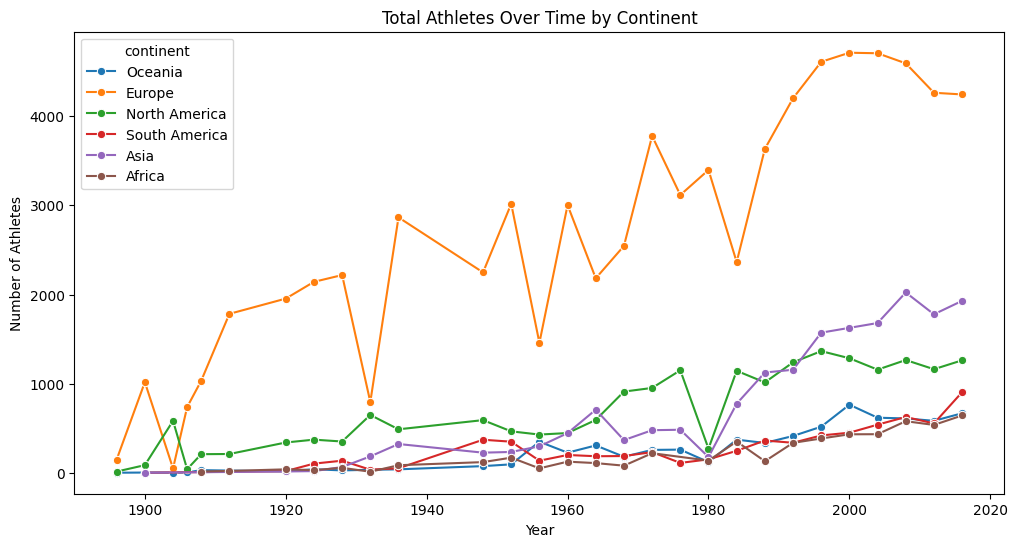

In [7]:
# Participation Trends

# number of athletes over time
plt.figure(figsize=(12,6))
sns.lineplot(
    data=country_year,
    x="Year",
    y="n_athletes",
    hue="continent",
    marker="o",
    estimator="sum",
    errorbar=None
)
plt.title("Total Athletes Over Time by Continent")
plt.ylabel("Number of Athletes")
plt.show()

#### Number of Participating Countries Over Time

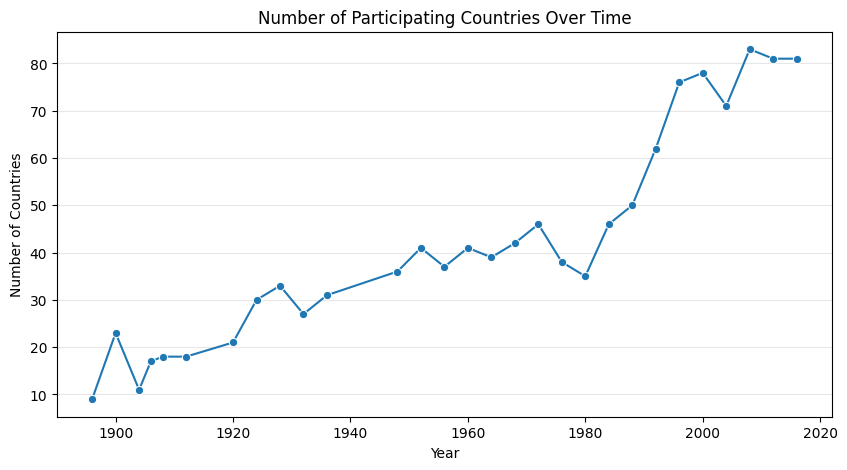

In [8]:
# Number of countries per year
countries_per_year = (
    country_year.groupby("Year")["country_name"]
    .nunique()
    .reset_index(name="n_countries")
)

plt.figure(figsize=(10,5))
sns.lineplot(data=countries_per_year, x="Year", y="n_countries", marker="o")
plt.title("Number of Participating Countries Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Countries")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

#### Number of Participating Countries by Continent Over Time

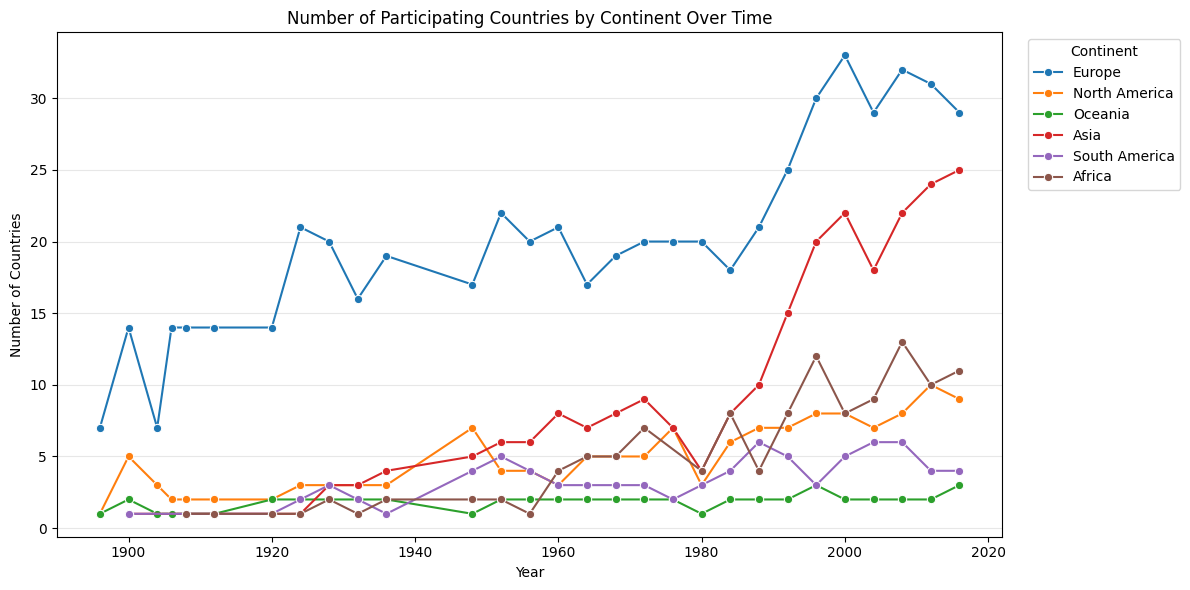

In [9]:
# Number of countries per year by continent
countries_per_year_continent = (
    country_year.groupby(["Year", "continent"])["country_name"]
    .nunique()
    .reset_index(name="n_countries")
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=countries_per_year_continent,
    x="Year", y="n_countries", hue="continent",
    marker="o"
)
plt.title("Number of Participating Countries by Continent Over Time")
plt.xlabel("Year"); plt.ylabel("Number of Countries")
plt.grid(True, axis='y', alpha=0.3)
plt.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

#### Share of Athletes by Continent

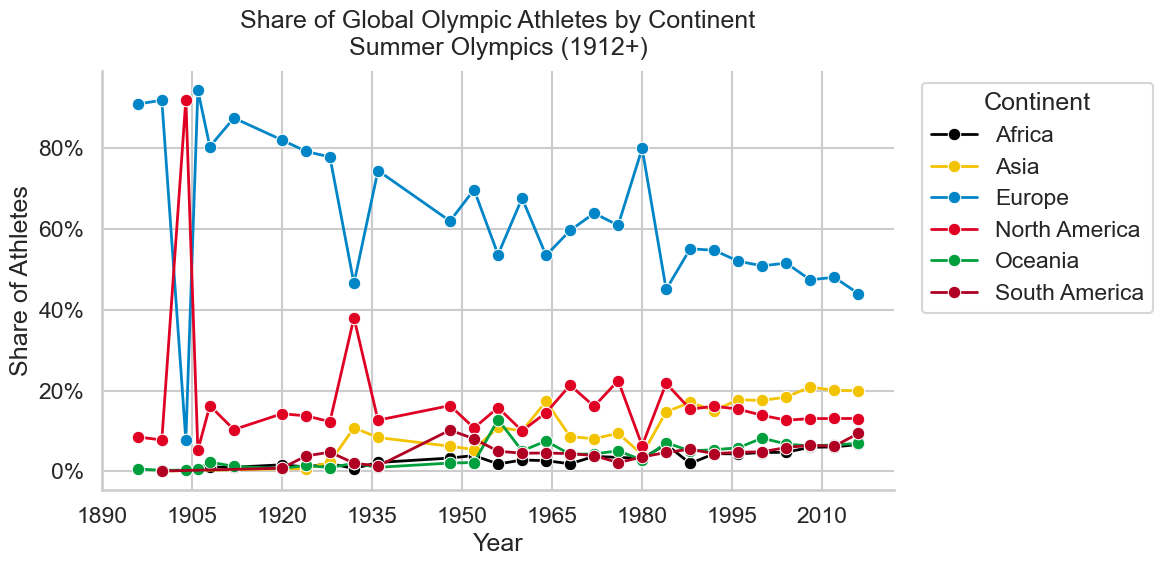

In [10]:
continent_colors = {
    "Europe":   "#0085C7",  # Blue
    "Asia":     "#F4C300",  # Yellow
    "Africa":   "#000000",  # Black
    "Oceania":  "#009F3D",  # Green
    "North America": "#DF0024",  # Red
    "South America": "#AF0024", 

}

# Share of athletes by contient
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=percent_athletes_continent_year, x='Year', y='pct', hue='continent', marker='o', linewidth=2, palette=continent_colors)
ax.set_title("Share of Global Olympic Athletes by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year"); ax.set_ylabel("Share of Athletes")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title='Continent', bbox_to_anchor=(1.02,1), loc='upper left')
sns.despine(); plt.tight_layout(); plt.show()

#### Continental Medal Share Over Time

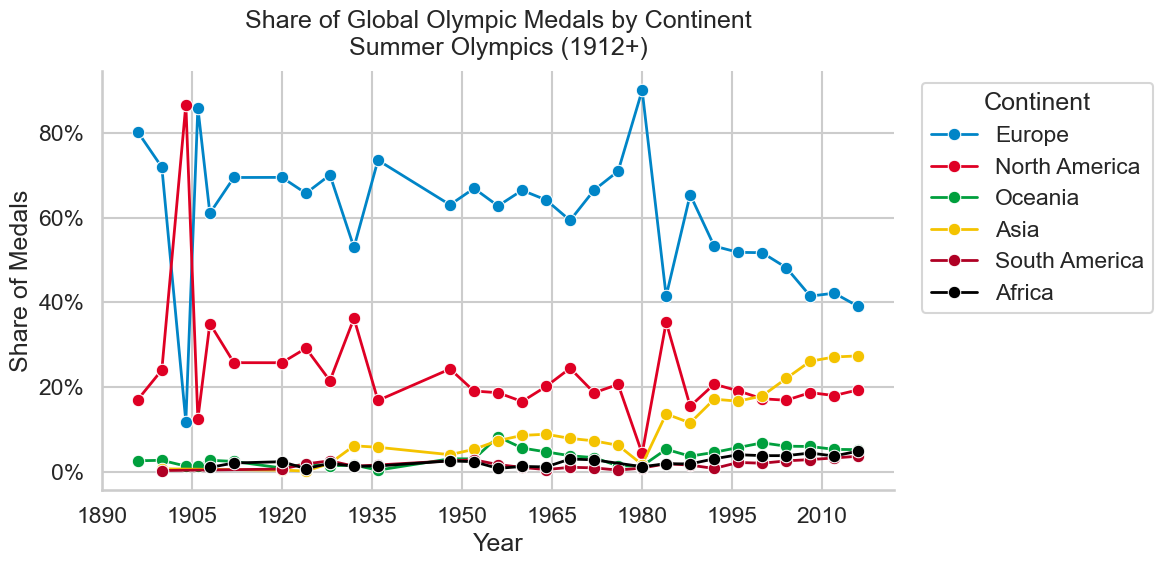

In [11]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=medals_continent_year,
    x="Year", y="medal_share", hue="continent",
    marker="o", linewidth=2, palette=continent_colors
)
ax.set_title("Share of Global Olympic Medals by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year")
ax.set_ylabel("Share of Medals")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
sns.despine(); plt.tight_layout(); plt.show()


#### Medal Efficiency (Medals per Athlete)

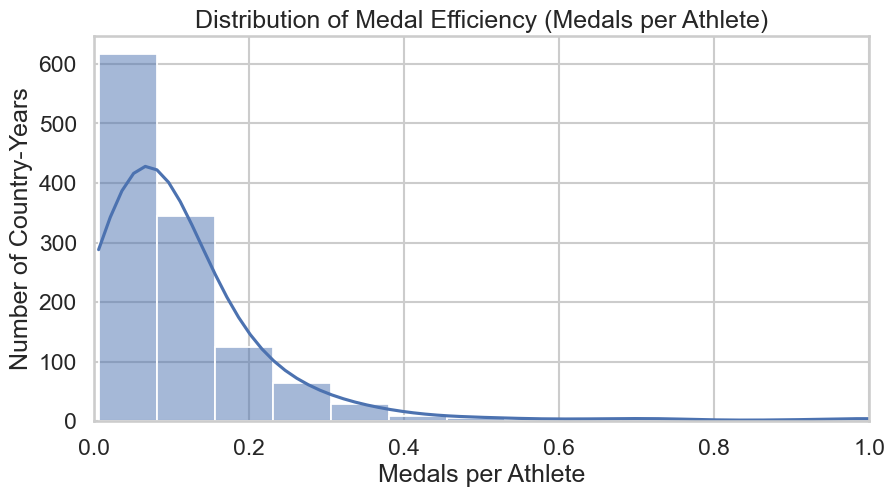

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=country_year,
    x="medals_per_athlete",
    bins=40,
    kde=True
)
plt.title("Distribution of Medal Efficiency (Medals per Athlete)")
plt.xlabel("Medals per Athlete")
plt.ylabel("Number of Country-Years")
plt.xlim(0, country_year["medals_per_athlete"].quantile(0.99))  # trim crazy outliers
plt.show()

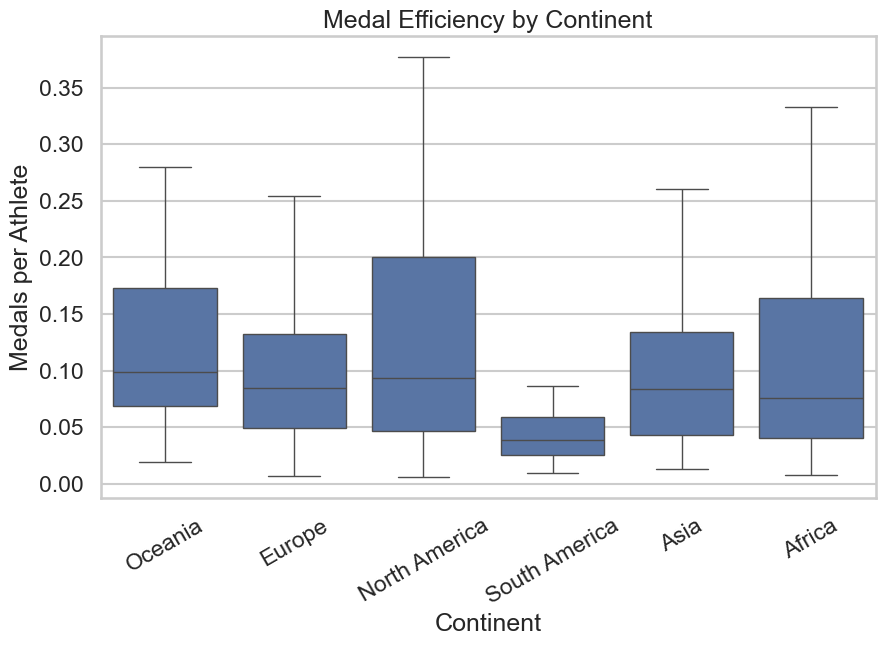

In [13]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=country_year,
    x="continent",
    y="medals_per_athlete",
    showfliers=False
)
plt.title("Medal Efficiency by Continent")
plt.xlabel("Continent")
plt.ylabel("Medals per Athlete")
plt.xticks(rotation=30)
plt.show()

#### Delagation Size vs Medal Count

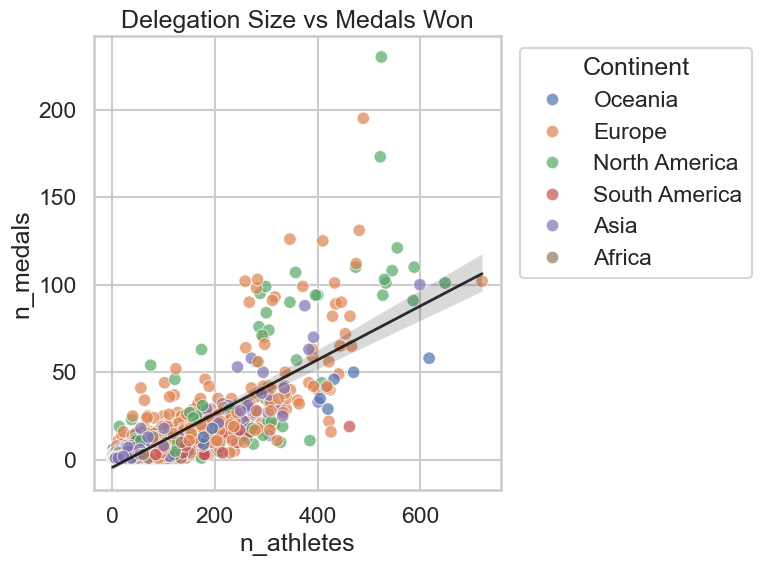

In [14]:
# Delagation size vs medals won
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=country_year,
    x="n_athletes",
    y="n_medals",
    hue="continent",
    alpha=0.7
)
plt.title("Delegation Size vs Medals Won")
plt.xlabel("Number of Athletes")
plt.ylabel("Number of Medals")

sns.regplot(
    data=country_year,
    x="n_athletes",
    y="n_medals",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2, "alpha": 0.8}
)
plt.legend(title="Continent", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

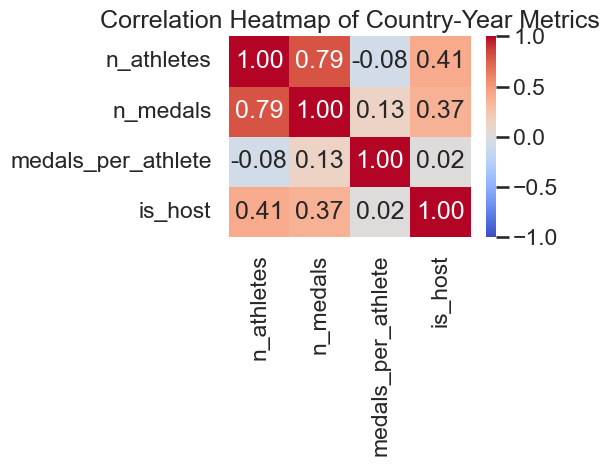

In [15]:
country_year.columns

num_cols = [
    "n_athletes",
    "n_medals",
    "medals_per_athlete",
    "is_host",
]

corr = country_year[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap of Country-Year Metrics")
plt.tight_layout()
plt.show()

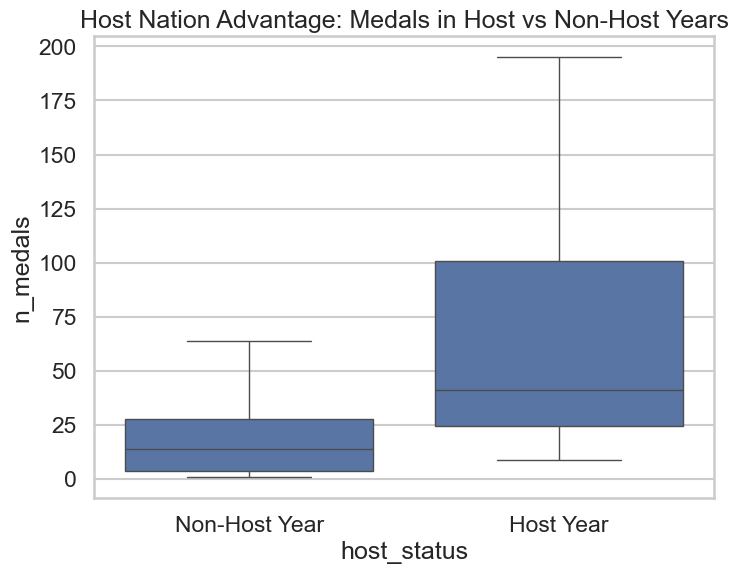

In [16]:
host_countries = country_year[country_year["is_host"] == 1]["country_name"].unique()
host_panel = country_year[country_year["country_name"].isin(host_countries)].copy()
host_panel["host_status"] = np.where(host_panel["is_host"] == 1, "Host Year", "Non-Host Year")

plt.figure(figsize=(8,6))
sns.boxplot(data=host_panel, x="host_status", y="n_medals", showfliers=False)
plt.title("Host Nation Advantage: Medals in Host vs Non-Host Years")
plt.show()

In [17]:
# choropleth map of total medals
total_medals_country = (
    country_year
    .groupby("country_name", as_index=False)["n_medals"]
    .sum()
)

# avoid weird values by adding a log-transformed version
total_medals_country["log_medals"] = np.log1p(total_medals_country["n_medals"])

fig = px.choropleth(
    total_medals_country,
    locations="country_name",
    locationmode="country names",
    color="log_medals",          
    hover_name="country_name",
    hover_data={"n_medals": True, "log_medals": False},
    color_continuous_scale="Viridis",
    title="Total Summer Olympic Medals by Country (1912+)",
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title="log(1 + medals)"
    )
)

fig.show()

C:\Users\Owen Schillaci\AppData\Local\Temp\ipykernel_3984\2733476659.py:11: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



## Models

Cross-validated R^2: -6.524551706189065


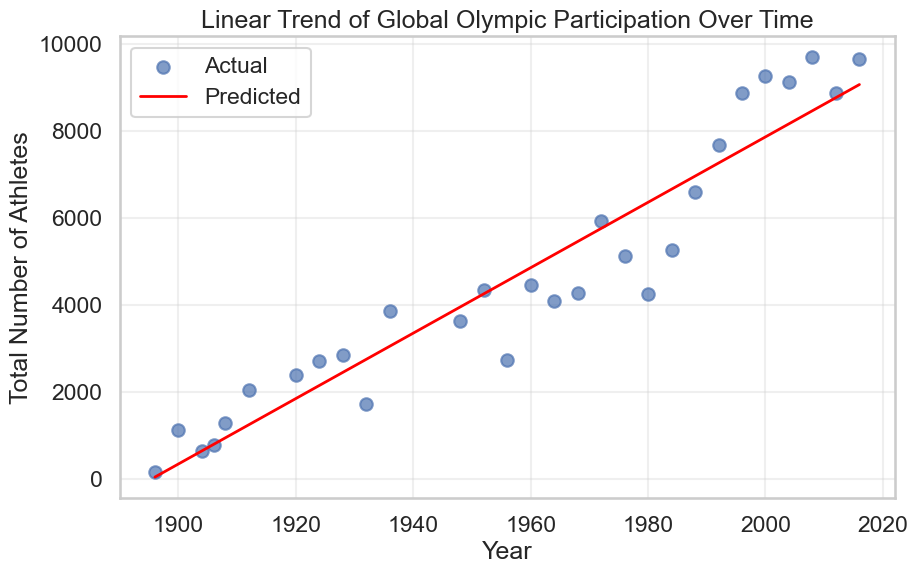

Intercept: -142611.12433041233
Slope: 75.2359558278164


In [18]:
# regression model for predicinting how participation will change over time
# n_athletes=β0​+β1​⋅Year

# aggregate participation per year
participation_year = (
    country_year.groupby("Year")["n_athletes"]
    .sum()
    .reset_index()
)

participation_year.head()

# fit a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# X must be 2D; y must be 1D
X = participation_year[["Year"]]
y = participation_year["n_athletes"]

model = LinearRegression()
model.fit(X, y)

# Evaluate the model using cross-validated R²
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2:", scores.mean())

# Plot the actual vs predicted trend
participation_year["predicted"] = model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(participation_year["Year"], participation_year["n_athletes"], label="Actual", alpha=0.7)
plt.plot(participation_year["Year"], participation_year["predicted"], color="red", label="Predicted", linewidth=2)

plt.title("Linear Trend of Global Olympic Participation Over Time")
plt.xlabel("Year")
plt.ylabel("Total Number of Athletes")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# print model coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

### Question 4. Does delegation size predict medal success? How strongly?
We used Random Forest Regression predicting total medal counts and viewing feature importance. 

Test R²: 0.8656858376562783
RMSE: 7.966426571759279


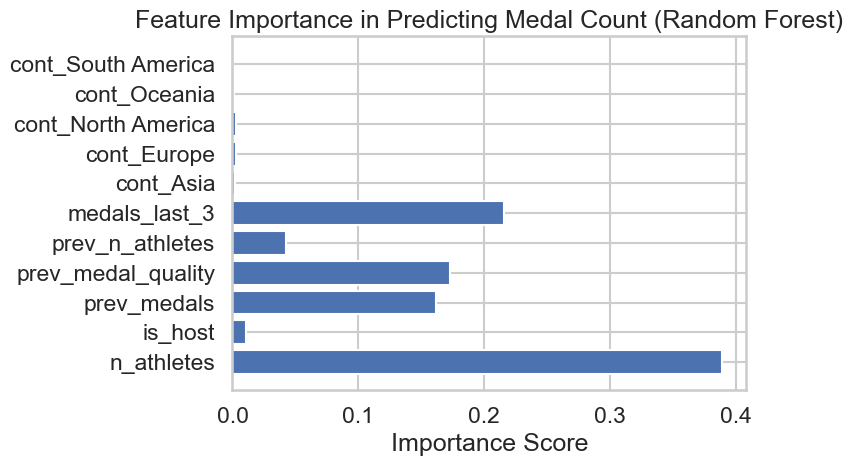

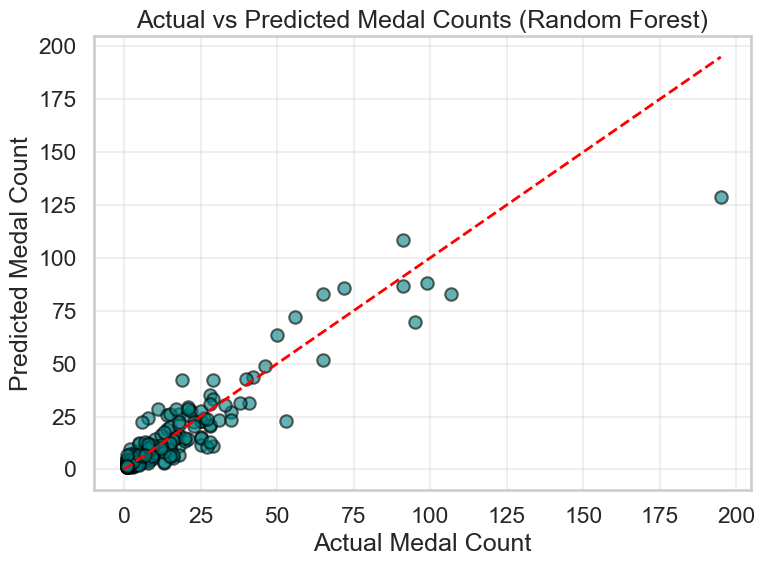

country_name  n_medals  predicted_medals
1147      Algeria         2          2.063333
1148    Argentina         4          5.986667
1149      Armenia         4          3.513333
1150    Australia        29         42.286667
1151      Austria         1          2.263333
1152   Azerbaijan        18          6.880000
1153      Bahamas         2          1.953333
1158      Bahrain         2          1.780000
1156      Belarus         9         11.426667
1155      Belgium         6          4.823333

In [ ]:
# ============================================
# Random Forest Model to Predict Medal Counts
# ============================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

model_df = country_year.dropna(subset=["continent"]).copy()
model_df = model_df.sort_values(["country_name", "Year"])

model_df["prev_medals"] = model_df.groupby("country_name")["n_medals"].shift(1)
model_df["prev_medal_quality"] = model_df.groupby("country_name")["total_medal_quality"].shift(1)
model_df["prev_n_athletes"] = model_df.groupby("country_name")["n_athletes"].shift(1)

# Rolling average of previous 3 Games
model_df["medals_last_3"] = (
    model_df.groupby("country_name")["n_medals"]
            .shift(1)                            # avoids data leakage
            .rolling(3, min_periods=1)
            .mean()
)

model_df = model_df.dropna( # drop rows with no olympic appearance before this
    subset=["prev_medals", "prev_medal_quality", "prev_n_athletes", "medals_last_3"]
)


X = model_df[[
    "n_athletes",
    "is_host",
    "prev_medals",
    "prev_medal_quality",
    "prev_n_athletes",
    "medals_last_3"
]]

X = pd.concat(
    [X, pd.get_dummies(model_df["continent"], prefix="cont", drop_first=True)], # one hot encoding for continents
    axis=1
)

y = model_df["n_medals"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature importance plot
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Feature Importance in Predicting Medal Count (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6)) 
plt.scatter(y_test, y_pred, alpha=0.6, color="teal", edgecolor="black") 
max_val = max(y_test.max(), y_pred.max()) 
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red", linewidth=2) 
plt.title("Actual vs Predicted Medal Counts (Random Forest)") 
plt.xlabel("Actual Medal Count") 
plt.ylabel("Predicted Medal Count") 
plt.grid(alpha=0.3) 
plt.tight_layout() 
plt.show() 

pred_last = model_df[model_df["Year"] == 2016].copy()  # we compare it to 2016 is this statistcally sound (?)
X_last = X.loc[pred_last.index] 
pred_last["predicted_medals"] = rf.predict(X_last) 
pred_last[["country_name", "n_medals", "predicted_medals"]].head(10)


Our model achieved a test R^2 = 0.866. This means that our model explains ~87% of variation in medal counts across all countries per year. This is a pretty strong predictive performance.

The RMSE = ~8 medals, which means that on average predicted medal counts are within 8 medals of true values. This is a small error relative to the 0-200 medal range. It shows that medal performance is very predictiable using just delegation size and recent history. 

Medal Efficiency Model Performance
-----------------------------------
R^2:  0.267
RMSE: 0.0637

Linear Regression Coefficients (Point Estimates):
              feature   coefficient
6  cont_North America  1.335440e-02
4           cont_Asia  4.763025e-03
0          n_athletes  3.529417e-05
1    athletes_squared  3.650643e-07
3                Year -7.307883e-04
5         cont_Europe -3.865527e-03
2             is_host -1.902977e-02
7        cont_Oceania -1.956277e-02
8  cont_South America -4.914113e-02

Bootstrap 95% Confidence Intervals for Coefficients:
              feature  coef_point_estimate  CI Lower (2.5%)  CI Upper (97.5%)
6  cont_North America         1.335440e-02    -7.239539e-03      4.193329e-02
4           cont_Asia         4.763025e-03    -1.182060e-02      2.610821e-02
0          n_athletes         3.529417e-05    -7.520172e-05      2.083904e-04
1    athletes_squared         3.650643e-07     6.180781e-09      6.574388e-07
3                Year        -7.307883e-04    -9.

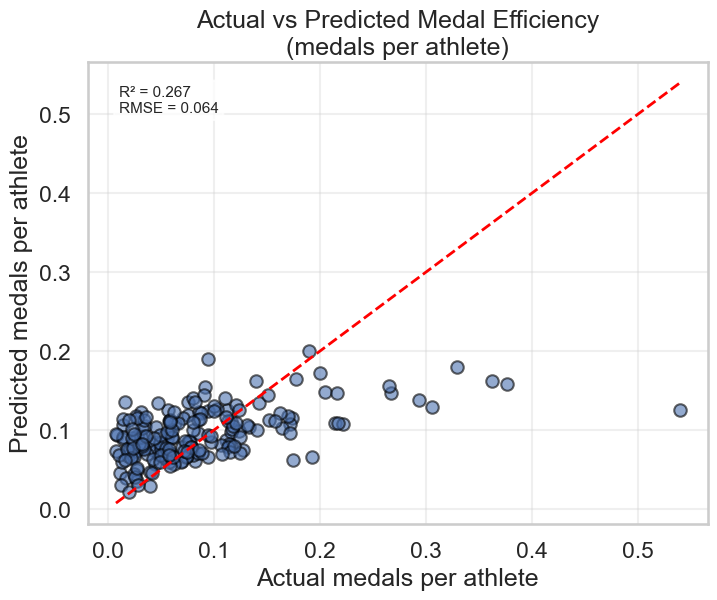

In [20]:
# fit to predict medals per athlete/medal efficiency

eff_df = country_year.dropna(subset=["continent", "medals_per_athlete"]).copy()

# Nonlinear feature: squared delegation size (captures diminishing returns)
eff_df["athletes_squared"] = eff_df["n_athletes"] ** 2
eff_df = eff_df[eff_df["n_athletes"] >= 30]

# Base features
feature_cols = ["n_athletes", "athletes_squared", "is_host", "Year"]

# One-hot encode continent and join to X
continent_dummies = pd.get_dummies(eff_df["continent"], prefix="cont", drop_first=True)

X = eff_df[feature_cols].join(continent_dummies)

y = eff_df["medals_per_athlete"] # target is medal efficiency

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_eff = LinearRegression()
lin_eff.fit(X_train, y_train)

y_pred = lin_eff.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Medal Efficiency Model Performance")
print("-----------------------------------")
print(f"R^2:  {r2:.3f}")
print(f"RMSE: {rmse:.4f}")

coeffs = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lin_eff.coef_
}).sort_values("coefficient", ascending=False)

print("\nLinear Regression Coefficients (Point Estimates):")
print(coeffs)

# Bootstrap
n_boot = 500  # number of bootstrap samples
boot_coefs = []

rng = np.random.default_rng(seed=42)

for _ in range(n_boot):
    sample_idx = rng.integers(low=0, high=len(X), size=len(X))
    
    X_boot = X.iloc[sample_idx]
    y_boot = y.iloc[sample_idx]
    
    model_boot = LinearRegression()
    model_boot.fit(X_boot, y_boot)
    boot_coefs.append(model_boot.coef_)

boot_coefs = np.array(boot_coefs)

# 2.5% and 97.5% percentiles for each coefficient
ci_lower = np.percentile(boot_coefs, 2.5, axis=0)
ci_upper = np.percentile(boot_coefs, 97.5, axis=0)

bootstrap_ci = pd.DataFrame({
    "feature": X.columns,
    "coef_point_estimate": lin_eff.coef_,
    "CI Lower (2.5%)": ci_lower,
    "CI Upper (97.5%)": ci_upper
}).sort_values("coef_point_estimate", ascending=False)

print("\nBootstrap 95% Confidence Intervals for Coefficients:")
print(bootstrap_ci)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="black")
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", linewidth=2)

plt.title("Actual vs Predicted Medal Efficiency\n(medals per athlete)")
plt.xlabel("Actual medals per athlete")
plt.ylabel("Predicted medals per athlete")
plt.grid(alpha=0.3)

plt.annotate(
    f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    ha="left", va="top",
    fontsize=11,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

plt.show()

In [21]:
# t-test for host nation advantage

# prepare the two groups
# Identify host countries
host_countries = country_year[country_year["is_host"] == 1]["country_name"].unique()

# Keep only rows for host countries (both host & non-host years)
host_panel = country_year[country_year["country_name"].isin(host_countries)].copy()

# Two groups
host_year_medals = host_panel[host_panel["is_host"] == 1]["n_medals"]
nonhost_year_medals = host_panel[host_panel["is_host"] == 0]["n_medals"]

# perform an independent two-sample t-test
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    host_year_medals,
    nonhost_year_medals,
    equal_var=False
)

print("T-statistic:", t_stat)
print("P-value:", p_value)

print("Average medals (host year):", host_year_medals.mean())
print("Average medals (non-host years):", nonhost_year_medals.mean())


T-statistic: 3.772051230397991
P-value: 0.0008562241104843524
Average medals (host year): 66.23076923076923
Average medals (non-host years): 22.70528967254408


In [22]:
# predict whether a nation will win any medal
# logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


cls_df = country_year.dropna(subset=["continent"]).copy()

# Target: whether a nation won any medal
cls_df["any_medal"] = (cls_df["n_medals"] > 0).astype(int)

# Features
feature_cols = ["n_athletes", "is_host", "Year"]

# One-hot encode continent
continent_dummies = pd.get_dummies(cls_df["continent"], prefix="cont", drop_first=True)

X = cls_df[feature_cols].join(continent_dummies)
y = cls_df["any_medal"]

# 2. Train-test split
# -------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 3. Fit logistic regression model
# --------------------------------

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# 4. Predictions + Evaluation
# ---------------------------

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. Coefficients table
# ---------------------

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values("coefficient", ascending=False)

print("\nLogistic Regression Coefficients:")
print(coef_df)

# Create a smooth range of delegation sizes
ath_range = np.linspace(1, 400, 400)  # 1 to 400 athletes

# Build a dataframe with typical values for other features
base_df = pd.DataFrame({
    "n_athletes": ath_range,
    "is_host": 0,
    "Year": country_year["Year"].mean(),   # average year
})

# Add continent dummies (set baseline = Africa)
for col in X.columns:
    if col.startswith("cont_"):
        base_df[col] = 0

# Predict probabilities
probs = log_reg.predict_proba(base_df[X.columns])[:, 1]

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix: Any Medal vs No Medal")
plt.xticks([0.5, 1.5], ["No Medal (0)", "Any Medal (1)"])
plt.yticks([0.5, 1.5], ["No Medal (0)", "Any Medal (1)"], rotation=0)
plt.tight_layout()
plt.show()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)

In [ ]:
# add geneder data to eda
# create custome docker file and remove import statements